# Project 1 - Energy Consumption Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb #Statistics data visualization base on matplotlib]
from scipy import stats
from datetime import date
import holidays
from sklearn.feature_selection import SelectKBest # selection method
from sklearn.feature_selection import mutual_info_regression,f_regression # score metric (f_regression)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn import  metrics 

# DATA PREPARATION

In [2]:
#Reading CSV from 2017,2018 and weather data
df_7 = pd.read_csv('IST_South_Tower_2017_Ene_Cons - IST_South_Tower_2017_Ene_Cons.csv')
df_8 = pd.read_csv('IST_South_Tower_2018_Ene_Cons - IST_South_Tower_2018_Ene_Cons.csv')
df_W = pd.read_csv('IST_meteo_data_2017_2018_2019 - IST_meteo_data_2017_2018_2019.csv')

#cleaning 2017-2018 file
df_7_8 = pd.concat([df_7,df_8])
df_7_8['Date_start']=pd.to_datetime(df_7_8['Date_start'])
dataset_P=df_7_8.set_index(['Date_start'],drop=True) 

#cleaning Weather file 
# =============================================================================
df_W['yyyy-mm-dd hh:mm:ss']=pd.to_datetime(df_W['yyyy-mm-dd hh:mm:ss'])
df_W=df_W.set_index(['yyyy-mm-dd hh:mm:ss'],drop=True)

# =============================================================================

#merging Consumption and weather 

dataset_f=pd.merge(dataset_P,df_W,how='outer',left_index=True, right_index=True)

#adding Holidays 
dataset_f = dataset_f.reset_index()
dataset_f['date'] = pd.to_datetime(dataset_f['index']).dt.date

pt_holidays = []
for date in holidays.Portugal(years=(2017,2018,2019)).items():
    pt_holidays.append(str(date[0]))
    
dataset_f['is_holidays']=[1 if str(val).split()[0] in pt_holidays else 0 for val in dataset_f['date']]   

dataset_f = dataset_f.drop('date',axis=1)

dataset_f=dataset_f.set_index(['index'],drop=True)

dataset_f

#Final data after cleaning and adding Holidays

,Power_kW,temp_C,HR,windSpeed_m/s,windGust_m/s,pres_mbar,solarRad_W/m2,rain_mm/h,rain_day,is_holidays
index,,,,,,,,,,
2017-01-01 00:00:00,100.810001,8.72,74.60,2.138,3.774,1029.0,1.163,0.0,0.0,1
2017-01-01 00:05:00,NaN,8.68,74.60,1.929,3.019,1029.0,1.496,0.0,0.0,1
2017-01-01 00:10:00,NaN,8.69,74.50,1.824,2.516,1029.0,1.025,0.0,0.0,1
2017-01-01 00:15:00,NaN,8.62,75.10,2.264,3.271,1029.0,1.690,0.0,0.0,1
2017-01-01 00:20:00,NaN,8.63,75.00,3.061,3.774,1029.0,1.108,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:48:00,NaN,11.19,58.60,0.000,0.000,1031.0,2.576,0.0,0.0,0
2018-12-31 23:53:00,NaN,11.21,58.75,0.000,0.000,1031.0,1.551,0.0,0.0,0
2018-12-31 23:53:00,NaN,11.21,58.75,0.000,0.000,1031.0,1.551,0.0,0.0,0


In [3]:
#checking for Nan and infinity values 
print(dataset_f.isna().sum())
print(dataset_f.isnull().sum())
print(dataset_f.isin([np.inf, -np.inf]).sum())


Power_kW         182894
temp_C            14387
HR                14387
windSpeed_m/s     14387
windGust_m/s      14387
pres_mbar         14387
solarRad_W/m2     14387
rain_mm/h         14387
rain_day          14387
is_holidays           0
dtype: int64
Power_kW         182894
temp_C            14387
HR                14387
windSpeed_m/s     14387
windGust_m/s      14387
pres_mbar         14387
solarRad_W/m2     14387
rain_mm/h         14387
rain_day          14387
is_holidays           0
dtype: int64
Power_kW         0
temp_C           0
HR               0
windSpeed_m/s    0
windGust_m/s     0
pres_mbar        0
solarRad_W/m2    0
rain_mm/h        0
rain_day         0
is_holidays      0
dtype: int64


In [4]:
# Nan values present as the weather data is for every 5 minutes timestamp and power consumption is for every hour so we need
# resample according to Hour to get the data with all non NaN values 

dataset_f=dataset_f.resample('H').mean()

dataset_f


,Power_kW,temp_C,HR,windSpeed_m/s,windGust_m/s,pres_mbar,solarRad_W/m2,rain_mm/h,rain_day,is_holidays
index,,,,,,,,,,
2017-01-01 00:00:00,100.810001,8.532500,74.966667,2.344500,3.270750,1029.000000,1.355083,0.0,0.0,1.0
2017-01-01 01:00:00,99.054135,7.930000,76.308333,2.692417,3.480333,1028.166667,1.477333,0.0,0.0,1.0
2017-01-01 02:00:00,98.539567,7.263417,80.275000,3.300250,4.067167,1028.000000,1.415083,0.0,0.0,1.0
2017-01-01 03:00:00,101.435784,6.831333,81.333333,3.534333,4.423583,1028.000000,1.542000,0.0,0.0,1.0
2017-01-01 04:00:00,98.481664,6.500250,81.241667,4.006000,5.262333,1028.000000,0.891000,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,97.217861,13.361667,54.013333,0.000000,0.000000,1031.000000,1.112333,0.0,0.0,0.0
2018-12-31 20:00:00,95.928710,12.810000,55.441667,0.000000,0.000000,1031.000000,1.322417,0.0,0.0,0.0
2018-12-31 21:00:00,85.652000,12.565000,55.291667,0.000000,0.000000,1031.000000,1.195500,0.0,0.0,0.0


In [5]:
print(dataset_f.isna().sum())
print(dataset_f.isnull().sum())
print(dataset_f.isin([np.inf, -np.inf]).sum())

Power_kW            2
temp_C           2134
HR               2134
windSpeed_m/s    2134
windGust_m/s     2134
pres_mbar        2134
solarRad_W/m2    2134
rain_mm/h        2134
rain_day         2134
is_holidays         0
dtype: int64
Power_kW            2
temp_C           2134
HR               2134
windSpeed_m/s    2134
windGust_m/s     2134
pres_mbar        2134
solarRad_W/m2    2134
rain_mm/h        2134
rain_day         2134
is_holidays         0
dtype: int64
Power_kW         0
temp_C           0
HR               0
windSpeed_m/s    0
windGust_m/s     0
pres_mbar        0
solarRad_W/m2    0
rain_mm/h        0
rain_day         0
is_holidays      0
dtype: int64


In [6]:
#New data was found out using other website to replace the NaN values df_W_1 is for new values 

df_W_1 = pd.read_csv('weather data 2017_18_19.csv')

df_W_1['yyyy-mm-dd hh:mm:ss']=pd.to_datetime(df_W_1['yyyy-mm-dd hh:mm:ss'])
df_W_1=df_W_1.set_index(['yyyy-mm-dd hh:mm:ss'],drop=True)

df_W_1

,temp_C,HR,pres_mbar,rain_mm/h,solarRad_W/m2,windSpeed_m/s,windGust_m/s
yyyy-mm-dd hh:mm:ss,,,,,,,
2017-01-01 00:00:00,7.4,92,1020.0,0.0,0,8.4,15.1
2017-01-01 01:00:00,7.3,92,1019.6,0.0,0,8.3,15.5
2017-01-01 02:00:00,7.0,92,1018.9,0.0,0,7.9,15.5
2017-01-01 03:00:00,6.8,92,1018.9,0.0,0,7.9,15.8
2017-01-01 04:00:00,6.1,94,1018.6,0.0,0,7.6,16.6
...,...,...,...,...,...,...,...
2018-12-31 19:00:00,11.9,82,1022.1,0.0,0,6.4,9.4
2018-12-31 20:00:00,10.8,86,1022.0,0.0,0,7.1,10.8
2018-12-31 21:00:00,10.2,86,1022.3,0.0,0,8.4,13.0


In [7]:
#checking for NaN values in new weather data

print(df_W_1.isna().sum())
print(df_W_1.isnull().sum())
print(df_W_1.isin([np.inf, -np.inf]).sum())

temp_C           0
HR               0
pres_mbar        0
rain_mm/h        0
solarRad_W/m2    0
windSpeed_m/s    0
windGust_m/s     0
dtype: int64
temp_C           0
HR               0
pres_mbar        0
rain_mm/h        0
solarRad_W/m2    0
windSpeed_m/s    0
windGust_m/s     0
dtype: int64
temp_C           0
HR               0
pres_mbar        0
rain_mm/h        0
solarRad_W/m2    0
windSpeed_m/s    0
windGust_m/s     0
dtype: int64


In [8]:
#Replacing the NaN value in old dataset with values from new dataset

dataset_f.where(~np.isnan(dataset_f), other = df_W_1, inplace = True)

print(dataset_f.isna().sum())
print(dataset_f.isnull().sum())
print(dataset_f.isin([np.inf, -np.inf]).sum())

Power_kW            2
temp_C              0
HR                  0
windSpeed_m/s       0
windGust_m/s        0
pres_mbar           0
solarRad_W/m2       0
rain_mm/h           0
rain_day         2134
is_holidays         0
dtype: int64
Power_kW            2
temp_C              0
HR                  0
windSpeed_m/s       0
windGust_m/s        0
pres_mbar           0
solarRad_W/m2       0
rain_mm/h           0
rain_day         2134
is_holidays         0
dtype: int64
Power_kW         0
temp_C           0
HR               0
windSpeed_m/s    0
windGust_m/s     0
pres_mbar        0
solarRad_W/m2    0
rain_mm/h        0
rain_day         0
is_holidays      0
dtype: int64


In [9]:
# Dropping rain_day( Data was not found easily - various websites checked - Can be check more if regression doesnt go good )  
# NaN value for Power which are only 2( 0.011% of total data )

dataset_f = dataset_f.drop(['rain_day'],axis=1)
dataset_f = dataset_f.dropna()

print(dataset_f.isna().sum())
print(dataset_f.isnull().sum())
print(dataset_f.isin([np.inf, -np.inf]).sum())
 

Power_kW         0
temp_C           0
HR               0
windSpeed_m/s    0
windGust_m/s     0
pres_mbar        0
solarRad_W/m2    0
rain_mm/h        0
is_holidays      0
dtype: int64
Power_kW         0
temp_C           0
HR               0
windSpeed_m/s    0
windGust_m/s     0
pres_mbar        0
solarRad_W/m2    0
rain_mm/h        0
is_holidays      0
dtype: int64
Power_kW         0
temp_C           0
HR               0
windSpeed_m/s    0
windGust_m/s     0
pres_mbar        0
solarRad_W/m2    0
rain_mm/h        0
is_holidays      0
dtype: int64


In [10]:
# Data cleaning done as no Nan And infinity values present 

# NOW MOVING TO EDA

# EXPLORATORY DATA ANALYSIS 

In [11]:
#Data set quick statistics 

dataset_f.describe()

,Power_kW,temp_C,HR,windSpeed_m/s,windGust_m/s,pres_mbar,solarRad_W/m2,rain_mm/h,is_holidays
count,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000
mean,175.740415,16.260783,61.544897,3.622548,5.592148,1017.893079,196.338376,0.054835,0.035621
std,113.667772,5.186695,17.916542,6.213627,10.501507,7.191589,277.722742,0.387357,0.185347
min,0.000000,2.948417,9.680833,0.000000,0.000000,979.916667,0.000000,0.000000,0.000000
25%,100.671034,12.415833,49.076875,0.000000,0.000000,1014.083333,1.370771,0.000000,0.000000
50%,111.593085,15.712917,63.808333,0.000000,0.000000,1018.000000,11.461917,0.000000,0.000000
75%,242.479556,19.327500,74.714583,4.959479,6.436479,1022.000000,349.912500,0.000000,0.000000
max,947.059190,41.048333,100.000000,48.600000,79.600000,1039.583333,1053.825000,16.408333,1.000000


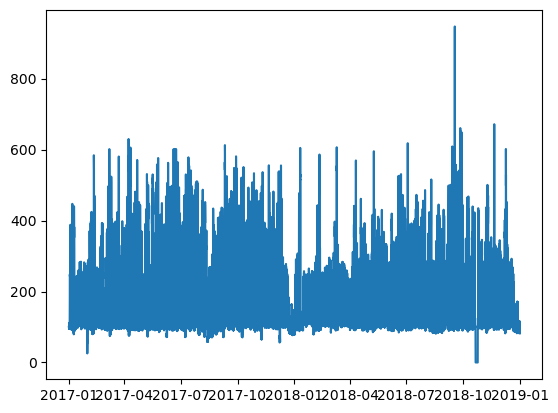

In [12]:
# From basic Statistics it can be seen that Power and Solarrad is having too much standard deviation 
# HR is also having more standard deviation but removing for it also reduce data too much - not good for regression 
# so for only 2 will analyze box plot and remove outliers 

# Boxplots and normal plots 
plt.plot(dataset_f['Power_kW'])


{'whiskers': [<matplotlib.lines.Line2D at 0x1e596541460>,
 'caps': [<matplotlib.lines.Line2D at 0x1e596541a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e596541160>],
 'medians': [<matplotlib.lines.Line2D at 0x1e596541fa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e59654f2b0>],
 'means': []}

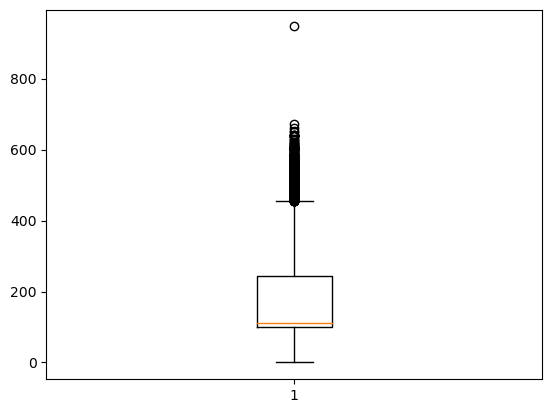

In [13]:
plt.boxplot(dataset_f['Power_kW'])


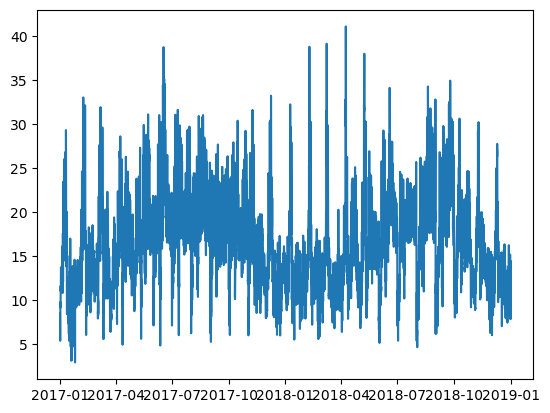

In [14]:
plt.plot(dataset_f['temp_C'])


{'whiskers': [<matplotlib.lines.Line2D at 0x1e5976cb730>,
 'caps': [<matplotlib.lines.Line2D at 0x1e5976cbcd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e5976cb460>],
 'medians': [<matplotlib.lines.Line2D at 0x1e5976d52b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e5976d5580>],
 'means': []}

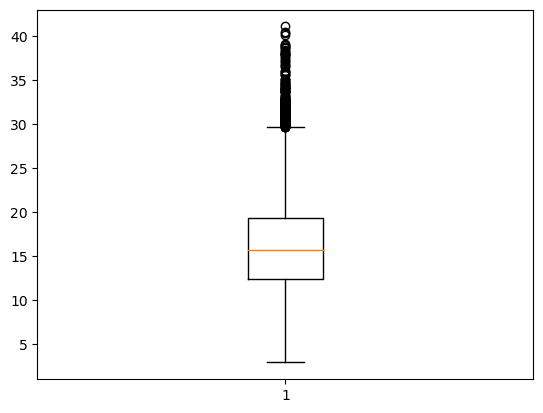

In [15]:
plt.boxplot(dataset_f['temp_C'])


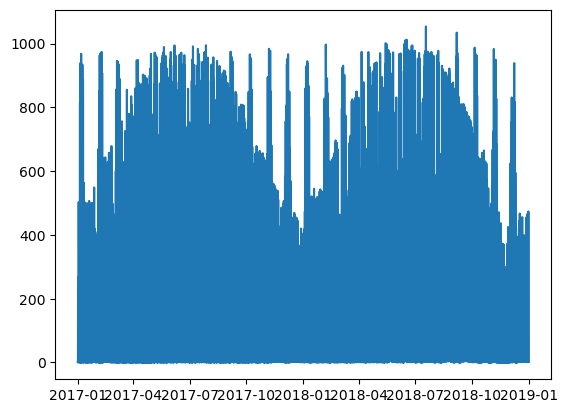

In [16]:
plt.plot(dataset_f['solarRad_W/m2'])


{'whiskers': [<matplotlib.lines.Line2D at 0x1e597e71280>,
 'caps': [<matplotlib.lines.Line2D at 0x1e597e71820>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e597e60f70>],
 'medians': [<matplotlib.lines.Line2D at 0x1e597e71dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e597e7d0d0>],
 'means': []}

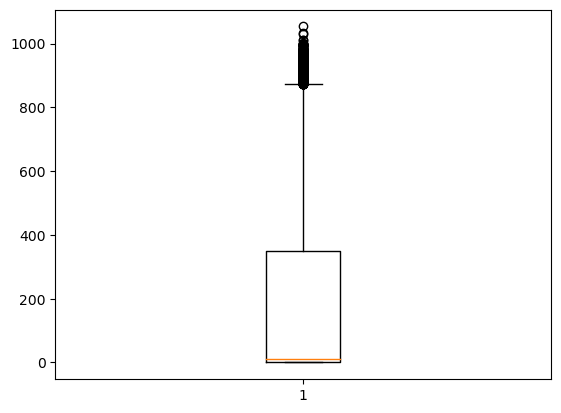

In [17]:
plt.boxplot(dataset_f['solarRad_W/m2'])

In [18]:
#removing outliners using Boxplot and zero SolarRad_W/m2 values 

Q1_1 = dataset_f['solarRad_W/m2'].quantile(0.25)
print(Q1_1)
Q3_1 = dataset_f['solarRad_W/m2'].quantile(0.75)
print(Q3_1)
IQR_1 = Q3_1 - Q1_1
print(IQR_1)
dataset_f=dataset_f[((dataset_f['solarRad_W/m2'] > (Q1_1 - 1.5 * IQR_1)) & (dataset_f['solarRad_W/m2'] < (Q3_1 + 1.5 * IQR_1)))]
dataset_f=dataset_f[((dataset_f['solarRad_W/m2'] > 0))]


#removing outliners using Boxplot and zero power values 

Q1 = dataset_f['Power_kW'].quantile(0.25)
print(Q1)
Q3 = dataset_f['Power_kW'].quantile(0.75)
print(Q3)
IQR = Q3 - Q1
print(IQR)
dataset_Zless3=dataset_f[((dataset_f['Power_kW'] > (Q1 - 1.5 * IQR)) & (dataset_f['Power_kW'] < (Q3 + 1.5 * IQR)))]
dataset_Zless3=dataset_Zless3[((dataset_Zless3['Power_kW'] > 0))]

dataset_Zless3

1.3707708333333333
349.9125
348.5417291666667
101.06903224999999
245.42936025
144.360328


,Power_kW,temp_C,HR,windSpeed_m/s,windGust_m/s,pres_mbar,solarRad_W/m2,rain_mm/h,is_holidays
index,,,,,,,,,
2017-01-01 00:00:00,100.810001,8.532500,74.966667,2.344500,3.270750,1029.000000,1.355083,0.0,1.0
2017-01-01 01:00:00,99.054135,7.930000,76.308333,2.692417,3.480333,1028.166667,1.477333,0.0,1.0
2017-01-01 02:00:00,98.539567,7.263417,80.275000,3.300250,4.067167,1028.000000,1.415083,0.0,1.0
2017-01-01 03:00:00,101.435784,6.831333,81.333333,3.534333,4.423583,1028.000000,1.542000,0.0,1.0
2017-01-01 04:00:00,98.481664,6.500250,81.241667,4.006000,5.262333,1028.000000,0.891000,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,97.217861,13.361667,54.013333,0.000000,0.000000,1031.000000,1.112333,0.0,0.0
2018-12-31 20:00:00,95.928710,12.810000,55.441667,0.000000,0.000000,1031.000000,1.322417,0.0,0.0
2018-12-31 21:00:00,85.652000,12.565000,55.291667,0.000000,0.000000,1031.000000,1.195500,0.0,0.0


In [19]:
# Checking for NaN and Infinity values 
print(dataset_Zless3.isna().sum())
print(dataset_Zless3.isnull().sum())
print(dataset_Zless3.isin([np.inf, -np.inf]).sum())

Power_kW         0
temp_C           0
HR               0
windSpeed_m/s    0
windGust_m/s     0
pres_mbar        0
solarRad_W/m2    0
rain_mm/h        0
is_holidays      0
dtype: int64
Power_kW         0
temp_C           0
HR               0
windSpeed_m/s    0
windGust_m/s     0
pres_mbar        0
solarRad_W/m2    0
rain_mm/h        0
is_holidays      0
dtype: int64
Power_kW         0
temp_C           0
HR               0
windSpeed_m/s    0
windGust_m/s     0
pres_mbar        0
solarRad_W/m2    0
rain_mm/h        0
is_holidays      0
dtype: int64


# FEATURE SELECTION 

In [20]:
# creating values for Date, Month, Hour 


dataset_Zless3['Month']=dataset_Zless3.index.month
dataset_Zless3['Hour']=dataset_Zless3.index.hour
dataset_Zless3['Week Day']=dataset_Zless3.index.dayofweek

#Creating some new columns and dropping some weather data not adding much value 
dataset_Zless3['Power-1']=dataset_Zless3['Power_kW'].shift(1)
dataset_Zless3['Power-2']=dataset_Zless3['Power_kW'].shift(2)
dataset_Zless3=dataset_Zless3.dropna()


dataset_Zless3

,Power_kW,temp_C,HR,windSpeed_m/s,windGust_m/s,pres_mbar,solarRad_W/m2,rain_mm/h,is_holidays,Month,Hour,Week Day,Power-1,Power-2
index,,,,,,,,,,,,,,
2017-01-01 02:00:00,98.539567,7.263417,80.275000,3.300250,4.067167,1028.0,1.415083,0.0,1.0,1,2,6,99.054135,100.810001
2017-01-01 03:00:00,101.435784,6.831333,81.333333,3.534333,4.423583,1028.0,1.542000,0.0,1.0,1,3,6,98.539567,99.054135
2017-01-01 04:00:00,98.481664,6.500250,81.241667,4.006000,5.262333,1028.0,0.891000,0.0,1.0,1,4,6,101.435784,98.539567
2017-01-01 05:00:00,97.805844,6.006417,81.008333,4.552833,6.079333,1028.0,1.375833,0.0,1.0,1,5,6,98.481664,101.435784
2017-01-01 06:00:00,94.464760,5.645833,80.441667,4.004417,5.346417,1027.0,0.988000,0.0,1.0,1,6,6,97.805844,98.481664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,97.217861,13.361667,54.013333,0.000000,0.000000,1031.0,1.112333,0.0,0.0,12,19,0,105.247736,102.152464
2018-12-31 20:00:00,95.928710,12.810000,55.441667,0.000000,0.000000,1031.0,1.322417,0.0,0.0,12,20,0,97.217861,105.247736
2018-12-31 21:00:00,85.652000,12.565000,55.291667,0.000000,0.000000,1031.0,1.195500,0.0,0.0,12,21,0,95.928710,97.217861


[0.16178996 0.06943574 0.04539964 0.05581999 0.09343985 0.27641801
 0.00965789 0.00924055 0.10469573 0.51693694 0.0553562  1.12935527
 0.77366525]
Feature Ranking (Linear Model, 1 features): [ 8  9  3  4 13 11  5  1 10  6  2  7 12]
Feature Ranking (Linear Model, 2 features): [ 7  8  2  3 12 10  4  1  9  5  1  6 11]
Feature Ranking (Linear Model, 3 features): [ 6  7  1  2 11  9  3  1  8  4  1  5 10]
[2.82585426e-02 8.76020827e-03 4.32092992e-03 4.27164013e-03
 7.66306267e-03 2.68390913e-02 8.90048241e-04 2.67333422e-04
 7.06456530e-03 8.83143243e-02 5.18890628e-03 7.86966502e-01
 3.11948457e-02]


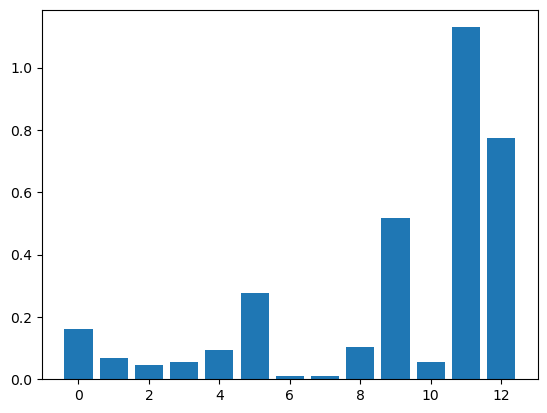

In [21]:

#Defining X and y values 
X = dataset_Zless3.iloc[:,1:15].values
y = dataset_Zless3.iloc[:,0].values


#Feature Selection F regression 

features=SelectKBest(k='all',score_func=mutual_info_regression) # Test different k number of features, uses f-test ANOVA

fit=features.fit(X,y) #calculates the scores using the score_function f_regression of the features
print(fit.scores_)
plt.bar([i for i in range(len(fit.scores_))], fit.scores_)

#Feature Selection recursive feature elimination 

model=LinearRegression() # LinearRegression Model as Estimator
rfe1=RFE(model,n_features_to_select=1)# using 1 features
rfe2=RFE(model,n_features_to_select=2) # using 2 features
rfe3=RFE(model,n_features_to_select=3)# using 3 features
fit1=rfe1.fit(X,y)
fit2=rfe2.fit(X,y)
fit3=rfe3.fit(X,y)

print( "Feature Ranking (Linear Model, 1 features): %s" % (fit1.ranking_)) 
print( "Feature Ranking (Linear Model, 2 features): %s" % (fit2.ranking_))
print( "Feature Ranking (Linear Model, 3 features): %s" % (fit3.ranking_)) 

# Feature analyze using random forest regression inbulit feature importance 

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X, y)
print(model.feature_importances_)

In [22]:
#considering all the 3 types Power-1, Power -2, Hour, Temp, Week of day can be considered as good in at least 2 models (f test and random forest test)
# remaining all values can be eliminated which can not be found good in any of the methos. 
dataset_Zless3 = dataset_Zless3.drop(['HR','windSpeed_m/s','windGust_m/s','pres_mbar','rain_mm/h','Month','is_holidays','Week Day'],axis=1)

X = dataset_Zless3.iloc[:, 1:6].values
y = dataset_Zless3.iloc[:,0].values
dataset_Zless3

,Power_kW,temp_C,solarRad_W/m2,Hour,Power-1,Power-2
index,,,,,,
2017-01-01 02:00:00,98.539567,7.263417,1.415083,2,99.054135,100.810001
2017-01-01 03:00:00,101.435784,6.831333,1.542000,3,98.539567,99.054135
2017-01-01 04:00:00,98.481664,6.500250,0.891000,4,101.435784,98.539567
2017-01-01 05:00:00,97.805844,6.006417,1.375833,5,98.481664,101.435784
2017-01-01 06:00:00,94.464760,5.645833,0.988000,6,97.805844,98.481664
...,...,...,...,...,...,...
2018-12-31 19:00:00,97.217861,13.361667,1.112333,19,105.247736,102.152464
2018-12-31 20:00:00,95.928710,12.810000,1.322417,20,97.217861,105.247736
2018-12-31 21:00:00,85.652000,12.565000,1.195500,21,95.928710,97.217861


# REGRESSION

In [23]:
# Spliting and Scaling 
#split Train n Test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

# Fearuture Scaling  

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)


# Random Forest Regression 

In [24]:
from sklearn.ensemble import RandomForestRegressor

reg1 = RandomForestRegressor().fit(X_train, y_train)

y_pred = reg1.predict(X_test)
output = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)
print(output)

MAE_RF=metrics.mean_absolute_error(y_test,y_pred) 
MBE_RF=np.mean(y_test-y_pred) #here we calculate MBE
MSE_RF=metrics.mean_squared_error(y_test,y_pred)  
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test,y_pred))
cvRMSE_RF=RMSE_RF/np.mean(y_test)
NMBE_RF=MBE_RF/np.mean(y_test)
print(MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF)

[[245.08859639 260.0405645 ]
 [ 86.61537087  85.3546215 ]
 [306.26760877 301.2286885 ]
 ...
 [ 98.99704482  96.3001605 ]
 [288.16701196 311.825283  ]
 [104.26730852 106.3157635 ]]
13.881390142625044 1.380551874181847 977.552011083252 31.26582816883717 0.1848097375367245 0.008160328526902069


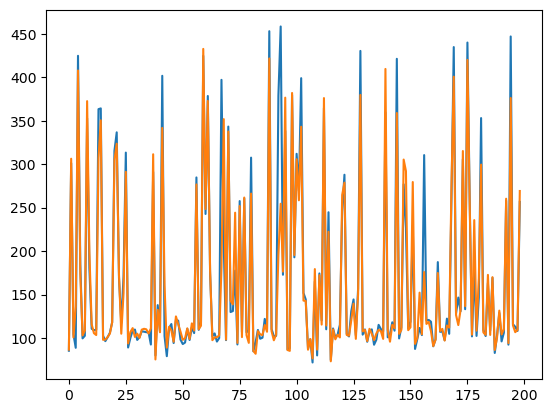

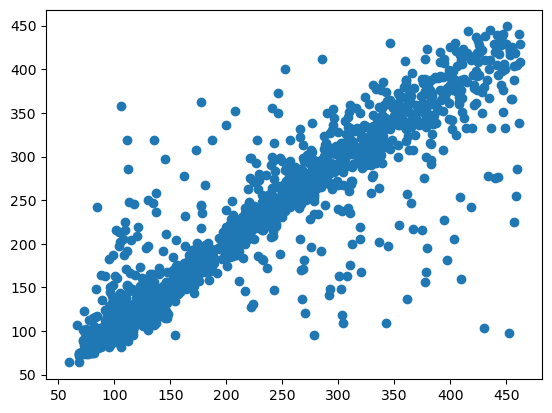

In [25]:
plt.plot(y_test[1:200])
plt.plot(y_pred[1:200])
plt.show()
plt.scatter(y_test,y_pred)

# MPL Regression 

In [26]:
from sklearn.neural_network import MLPRegressor

reg2 = MLPRegressor(hidden_layer_sizes=(5,10,5),max_iter=10000).fit(X_train, y_train)

y_pred = reg2.predict(X_test)
output = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)
print(output)

MAE_RF=metrics.mean_absolute_error(y_test,y_pred) 
MBE_RF=np.mean(y_test-y_pred) #here we calculate MBE
MSE_RF=metrics.mean_squared_error(y_test,y_pred)  
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test,y_pred))
cvRMSE_RF=RMSE_RF/np.mean(y_test)
NMBE_RF=MBE_RF/np.mean(y_test)
print(MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF)

[[231.21867573 260.0405645 ]
 [ 82.05150056  85.3546215 ]
 [320.95743376 301.2286885 ]
 ...
 [ 92.52588556  96.3001605 ]
 [287.47903652 311.825283  ]
 [101.00816984 106.3157635 ]]
18.364123016103527 0.7564685686891937 1294.0325245347615 35.972663572979435 0.21263145429953514 0.00447142346203942


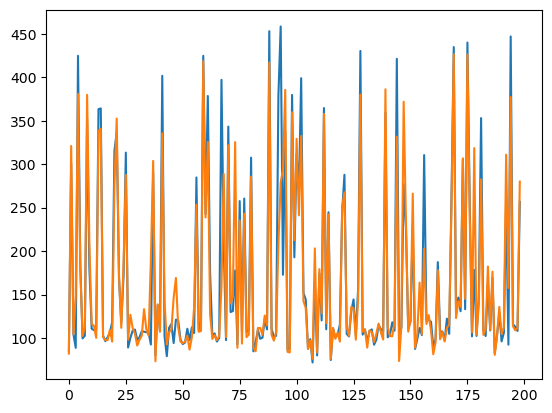

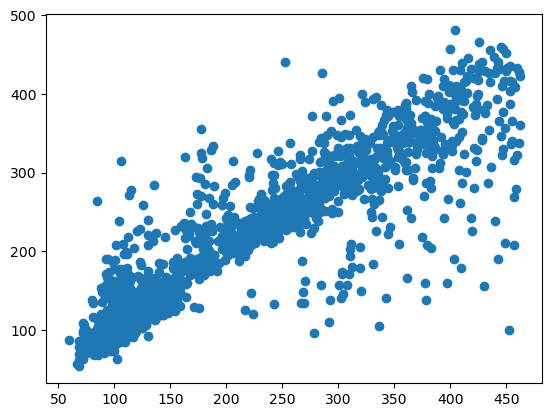

In [27]:
plt.plot(y_test[1:200])
plt.plot(y_pred[1:200])
plt.show()
plt.scatter(y_test,y_pred)

# Decision Tree Regressor

In [28]:
from sklearn.tree import DecisionTreeRegressor

reg3 = DecisionTreeRegressor().fit(X_train, y_train)

y_pred = reg3.predict(X_test)
output = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)
print(output)

MAE_RF=metrics.mean_absolute_error(y_test,y_pred) 
MBE_RF=np.mean(y_test-y_pred) #here we calculate MBE
MSE_RF=metrics.mean_squared_error(y_test,y_pred)  
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test,y_pred))
cvRMSE_RF=RMSE_RF/np.mean(y_test)
NMBE_RF=MBE_RF/np.mean(y_test)
print(MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF)

[[257.0637205 260.0405645]
 [ 81.366778   85.3546215]
 [254.2197245 301.2286885]
 ...
 [ 94.218511   96.3001605]
 [453.769001  311.825283 ]
 [101.1447425 106.3157635]]
17.636596974163634 1.9065254773103675 1812.5123469693276 42.57361092236983 0.2516491109100348 0.011269315214237349


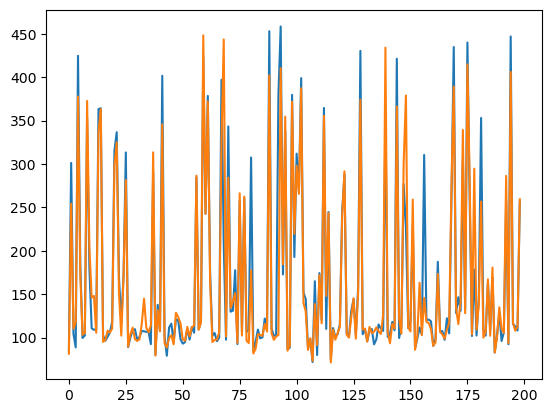

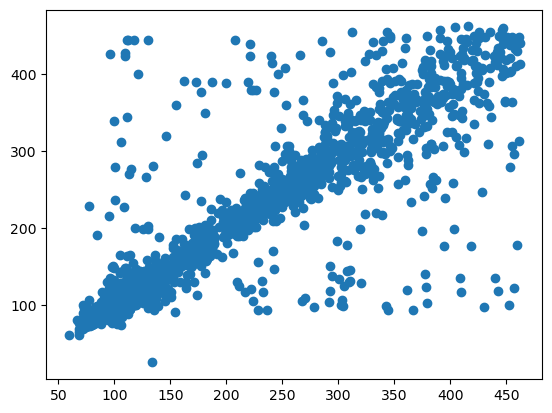

In [29]:
plt.plot(y_test[1:200])
plt.plot(y_pred[1:200])
plt.show()
plt.scatter(y_test,y_pred)

# XGBoost Regressor

In [30]:
from xgboost import XGBRegressor

reg4 = XGBRegressor().fit(X_train, y_train)

y_pred = reg4.predict(X_test)
output = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)
print(output)

MAE_RF=metrics.mean_absolute_error(y_test,y_pred) 
MBE_RF=np.mean(y_test-y_pred) #here we calculate MBE
MSE_RF=metrics.mean_squared_error(y_test,y_pred)  
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test,y_pred))
cvRMSE_RF=RMSE_RF/np.mean(y_test)
NMBE_RF=MBE_RF/np.mean(y_test)
print(MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF)

[[242.8762207  260.0405645 ]
 [ 89.78533173  85.3546215 ]
 [335.39395142 301.2286885 ]
 ...
 [ 99.25953674  96.3001605 ]
 [328.72714233 311.825283  ]
 [103.00331116 106.3157635 ]]
14.669422502991472 1.7284894689353496 1035.619950187713 32.18104955074823 0.1902195358144354 0.010216959018770646


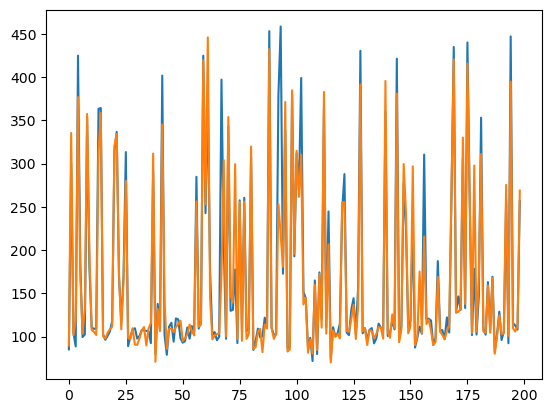

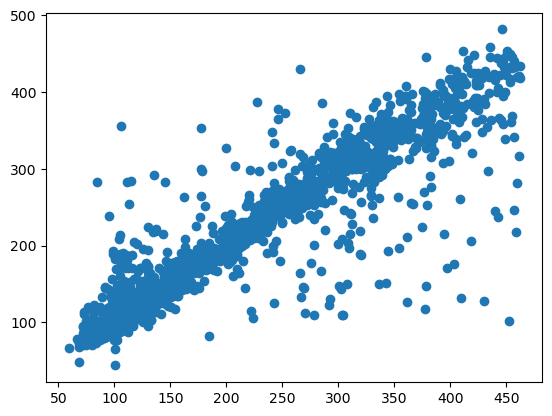

In [31]:
plt.plot(y_test[1:200])
plt.plot(y_pred[1:200])
plt.show()
plt.scatter(y_test,y_pred)

# Improving Random forest using hyperparameter Tuning 

In [32]:
# best model is Random forest from initial analysis
# Reason - 18% CVRMSE - (Below 20(IPMVP) and 30(ASHRAE)) ---- 0.8 % NMBE - (Below 5(IPMVP) - 10(ASHRAE))
# Now we try using some internal features to improve random forest model 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_


{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'n_estimators': 733,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

# VALIDATION USING BEST PARAMETERS 

In [33]:
#best parameter found out for the random forest regression now using those as final for regression 

reg_f = RandomForestRegressor(n_estimators=733, max_depth=30, min_samples_split=5, min_samples_leaf=1, max_features='sqrt',bootstrap=True).fit(X_train, y_train)
                              
y_pred = reg_f.predict(X_test)
output = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)
print(output)

MAE_RF=metrics.mean_absolute_error(y_test,y_pred) 
MBE_RF=np.mean(y_test-y_pred) #here we calculate MBE
MSE_RF=metrics.mean_squared_error(y_test,y_pred)  
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test,y_pred))
cvRMSE_RF=RMSE_RF/np.mean(y_test)
NMBE_RF=MBE_RF/np.mean(y_test)
print(MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF)                           

[[246.5180729  260.0405645 ]
 [ 86.32756993  85.3546215 ]
 [310.48665779 301.2286885 ]
 ...
 [ 99.99102963  96.3001605 ]
 [304.37085093 311.825283  ]
 [103.88875831 106.3157635 ]]
13.385513279620533 1.5257706338888222 913.760697852756 30.22847495082668 0.1786780280256847 0.009018704665922885


In [34]:
# Model Performance improved from 18.5% to 17.8% cvRMSE and NMBE is almost same. So Now Model Save and Testing on 2019 data. 

# MODEL SAVING

In [35]:
import pickle

#savemodel 
with open('reg_f.pkl','wb') as file:
    pickle.dump(reg_f, file)

# DEPLOYMENT - Testing with 2019 data

In [36]:
#model load

with open('reg_f.pkl','rb') as file:
    reg_f=pickle.load(file)

In [37]:
dataset_2019 = pd.read_csv('2019_withFeatures_Vivek_ist1105531.csv')

X_F = dataset_2019.iloc[:, 2:7].values
y_F = dataset_2019.iloc[:, 1].values

from sklearn.model_selection import train_test_split
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X_F, y_F, test_size = 0.2, random_state = 42) 

# Fearuture Scaling  

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_F = sc.fit_transform(X_train_F)
X_test_F = sc.fit_transform(X_test_F)

In [38]:
y_pred_F = reg_f.predict(X_test_F)

MAE_RF=metrics.mean_absolute_error(y_test_F,y_pred_F) 
MBE_RF=np.mean(y_test_F-y_pred_F) #here we calculate MBE
MSE_RF=metrics.mean_squared_error(y_test_F,y_pred_F)  
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test_F,y_pred_F))
cvRMSE_RF=RMSE_RF/np.mean(y_test_F)
NMBE_RF=MBE_RF/np.mean(y_test_F)
print(MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF)

13.53687944070524 2.4774518583704697 744.1370106696482 27.278874805784206 0.1637104483133924 0.01486808958567003


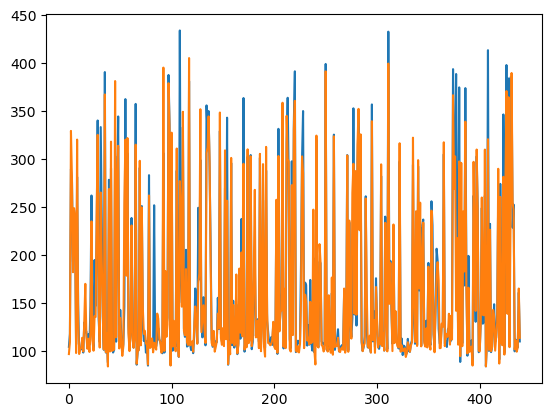

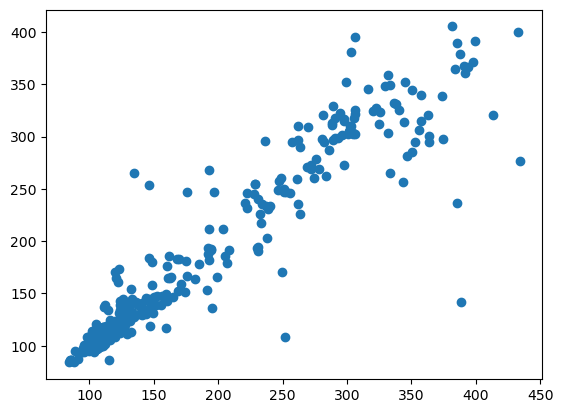

In [39]:
plt.plot(y_test_F)
plt.plot(y_pred_F)
plt.show()
plt.scatter(y_test_F,y_pred_F)

CVRMSE (16.55%) and NMBE(+1.5%) within both ASHRAE and IPMVP Limits 
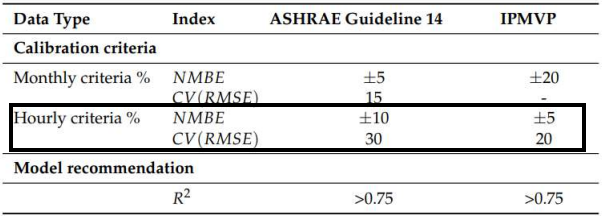

# THE END Thanks for going through project 